# Set the context 

In [1]:
import mxnet as mx
from mxnet import gluon,autograd,nd

In [77]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

# Build the dataset

In [78]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:,0] - 3.4 * X[:,1] + 4.2

X = nd.random_normal(shape=(num_examples,num_inputs))
noise = 0.01 * nd.random_normal(shape=(num_examples,))
y = real_fn(X) + noise


In [79]:
print(X[:1,:])
print(y[0])


[[ 0.03996059 -0.42665935]]
<NDArray 1x2 @cpu(0)>

[ 5.73883295]
<NDArray 1 @cpu(0)>


# Load the data iterator

In [65]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X,y),batch_size=batch_size,shuffle=True)

In [80]:
for i,(data,label) in enumerate(train_data):
    print(data,label)
    break


[[-0.43861517  0.23451599]
 [ 0.47872341 -0.50674367]
 [-0.05175154 -1.6741308 ]
 [-0.70555496  0.58734608]]
<NDArray 4x2 @cpu(0)> 
[ 2.50809121  6.88201523  9.7803793   0.82045788]
<NDArray 4 @cpu(0)>


# Define the model 

In [81]:
net = gluon.nn.Dense(1)

In [82]:
print(net.weight)
print(net.bias)

Parameter dense2_weight (shape=(1, 0), dtype=<class 'numpy.float32'>)
Parameter dense2_bias (shape=(1,), dtype=<class 'numpy.float32'>)


In [83]:

net.collect_params()

dense2_ (
  Parameter dense2_weight (shape=(1, 0), dtype=<class 'numpy.float32'>)
  Parameter dense2_bias (shape=(1,), dtype=<class 'numpy.float32'>)
)

# Initialize parameters 

In [84]:
net.collect_params().initialize(mx.init.Normal(sigma=1.),ctx=model_ctx)

# Define loss 

In [85]:
square_loss = gluon.loss.L2Loss()

# Optimizer 

In [86]:
trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.1})

#  Excute training loop 

In [87]:
epochs = 10
loss_sequence = []

for e in range(epochs):
    cumulative_loss = 0
    for i ,(data,label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        
        with autograd.record():
            output = net(data)
            loss = square_loss(output,label)
        
        loss.backward()
        
        trainer.step(batch_size)
        cumulative_loss += nd.mean(loss).asscalar()
    print("Epoch %s, loss: %s" % (e,cumulative_loss / num_examples))
    loss_sequence.append(cumulative_loss)


Epoch 0, loss: 0.0151946953946
Epoch 1, loss: 1.29914942677e-05
Epoch 2, loss: 1.29674872545e-05
Epoch 3, loss: 1.30099932828e-05
Epoch 4, loss: 1.29454844962e-05
Epoch 5, loss: 1.29662551973e-05
Epoch 6, loss: 1.29989393153e-05
Epoch 7, loss: 1.29875841817e-05
Epoch 8, loss: 1.30211719197e-05
Epoch 9, loss: 1.29536486534e-05


# Visualizing the learning curve 

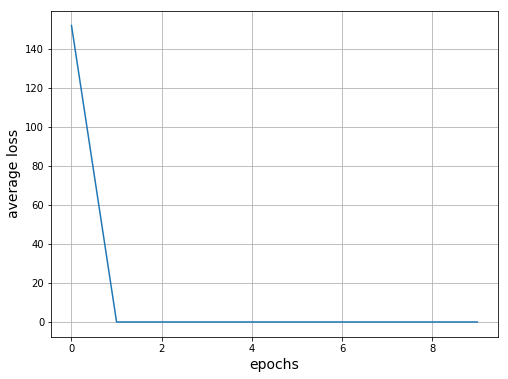

In [90]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8,6))
plt.plot(loss_sequence)

plt.grid(True,which="both")
plt.xlabel("epochs",fontsize=14)
plt.ylabel("average loss",fontsize=14)
plt.show()